In [16]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from skimage.draw import ellipse
from skimage.io import imsave

# Folder setup
image_dir = "images"
csv_dir = "csv"
mask_dir = "masks"
os.makedirs(mask_dir, exist_ok=True)

def create_instance_mask(image, df):
    mask = np.zeros(image.shape[:2], dtype=np.int32)
    current_label = 1

    for _, row in df.iterrows():
        cy, cx = int(row["Centroid Y pixel"]), int(row["Centroid X pixel"])
        max_c = int(row["max caliper pixel"])
        min_c = int(row["min caliper pixel"])

        rr, cc = ellipse(cy, cx, min_c // 2, max_c // 2, shape=mask.shape)
        mask[rr, cc] = current_label
        current_label += 1

    return mask

def slice_image_and_mask(image, mask, patch_size):
    h, w = image.shape[:2]
    patches = []

    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            img_patch = image[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            patches.append({
                "image": img_patch,
                "mask": mask_patch,
                "x_offset": x,
                "y_offset": y
            })

    return patches

def assign_centroids_to_patches(df, patch_size):
    patch_dict = {}

    for _, row in df.iterrows():
        x, y = int(row["Centroid X pixel"]), int(row["Centroid Y pixel"])
        patch_x = x // patch_size
        patch_y = y // patch_size
        rel_x = x % patch_size
        rel_y = y % patch_size
        patch_key = (patch_x, patch_y)

        if patch_key not in patch_dict:
            patch_dict[patch_key] = []

        patch_dict[patch_key].append({"x": rel_x, "y": rel_y})

    return patch_dict

def evaluate_patch(mask, centroids):
    total = len(centroids)
    assigned = 0
    label_counts = {}

    for c in centroids:
        x = int(c["x"])
        y = int(c["y"])
        if x < 0 or y < 0 or y >= mask.shape[0] or x >= mask.shape[1]:
            continue
        label = mask[y, x]
        if label > 0:
            assigned += 1
            label_counts[label] = label_counts.get(label, 0) + 1

    percent_assigned = assigned / total * 100 if total > 0 else 0
    shared_cells = sum(1 for count in label_counts.values() if count > 1)
    percent_shared = shared_cells / len(label_counts) * 100 if label_counts else 0

    return {
        "Total centroids": total,
        "Assigned": assigned,
        "% assigned": percent_assigned,
        "% shared cells": percent_shared
    }

# === Process All Images ===
for file in os.listdir(image_dir):
    if not file.endswith(".png"):
        continue

    base_name = os.path.splitext(file)[0]
    image_path = os.path.join(image_dir, file)
    csv_path = os.path.join(csv_dir, file + ".csv")
    mask_path = os.path.join(mask_dir, base_name + "_mask.png")

    if not os.path.exists(csv_path):
        print(f"⚠️ CSV not found for {file}, skipping.")
        continue

    print(f"🧪 Processing: {file}")
    image = cv2.imread(image_path)
    df = pd.read_csv(csv_path)

    mask = create_instance_mask(image, df)

    # Save visual binary mask
    imsave(mask_path, (mask > 0).astype(np.uint8) * 255)

    # Slice and evaluate
    patches = slice_image_and_mask(image, mask, patch_size=256)
    centroid_dict = assign_centroids_to_patches(df, patch_size=256)

    for patch in patches:
        key = (patch["x_offset"] // 256, patch["y_offset"] // 256)
        centroids = centroid_dict.get(key, [])
        result = evaluate_patch(patch["mask"], centroids)
        print(f"  ▪️ Patch {key}: {result}")


Streaming output truncated to the last 5000 lines.
  ▪️ Patch (7, 10): {'Total centroids': 41, 'Assigned': 41, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Patch (8, 10): {'Total centroids': 43, 'Assigned': 43, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Patch (9, 10): {'Total centroids': 46, 'Assigned': 46, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Patch (10, 10): {'Total centroids': 40, 'Assigned': 40, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Patch (11, 10): {'Total centroids': 53, 'Assigned': 53, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Patch (12, 10): {'Total centroids': 44, 'Assigned': 44, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Patch (13, 10): {'Total centroids': 44, 'Assigned': 44, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Patch (14, 10): {'Total centroids': 51, 'Assigned': 51, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Patch (15, 10): {'Total centroids': 44, 'Assigned': 44, '% assigned': 100.0, '% shared cells': 0.0}
  ▪️ Pa

 Mask Validation Script

In [21]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

mask_dir = "masks"
min_size = 1  # Min width/height of a bounding box

bad_files = []

for file in sorted(os.listdir(mask_dir)):
    if not file.endswith(".png"):
        continue

    path = os.path.join(mask_dir, file)
    mask = np.array(Image.open(path))

    if np.max(mask) == 0:
        print(f"❌ EMPTY MASK: {file}")
        bad_files.append(file)
        continue

    unique_labels = np.unique(mask)
    issues_found = False

    for label in unique_labels:
        if label == 0:
            continue  # Skip background

        binary = (mask == label).astype(np.uint8)
        y, x = np.where(binary)
        if len(x) == 0 or len(y) == 0:
            print(f"⚠️  Empty object for label {label} in {file}")
            issues_found = True
            continue

        xmin, xmax = np.min(x), np.max(x)
        ymin, ymax = np.min(y), np.max(y)

        if xmax - xmin < min_size or ymax - ymin < min_size:
            print(f"⚠️  Invalid box size (too small) in {file} for label {label}")
            issues_found = True

    if not issues_found:
        print(f"✅ {file} — OK")

print(f"\nChecked {len(os.listdir(mask_dir))} files. {len(bad_files)} empty.")


✅ NUH_A3_211024_Core_1_1_A_mask.png — OK
✅ NUH_A3_211024_Core_1_1_B_mask.png — OK
✅ NUH_A3_211024_Core_1_1_C_mask.png — OK
✅ NUH_A3_211024_Core_1_1_D_mask.png — OK
✅ NUH_A3_211024_Core_1_1_E_mask.png — OK
✅ NUH_A3_211024_Core_1_1_G_mask.png — OK
✅ NUH_A3_211024_Core_1_2_A_mask.png — OK
✅ NUH_A3_211024_Core_1_2_B_mask.png — OK
✅ NUH_A3_211024_Core_1_2_C_mask.png — OK
✅ NUH_A3_211024_Core_1_2_D_mask.png — OK
✅ NUH_A3_211024_Core_1_2_F_mask.png — OK
✅ NUH_A3_211024_Core_1_2_G_mask.png — OK
✅ NUH_A3_211024_Core_1_2_H_mask.png — OK
✅ NUH_A3_211024_Core_1_3_A_mask.png — OK
✅ NUH_A3_211024_Core_1_3_B_mask.png — OK
✅ NUH_A3_211024_Core_1_3_C_mask.png — OK
✅ NUH_A3_211024_Core_1_3_D_mask.png — OK
✅ NUH_A3_211024_Core_1_3_E_mask.png — OK
✅ NUH_A3_211024_Core_1_3_F_mask.png — OK
✅ NUH_A3_211024_Core_1_3_H_mask.png — OK
✅ NUH_A3_211024_Core_1_4_B_mask.png — OK
✅ NUH_A3_211024_Core_1_4_C_mask.png — OK
✅ NUH_A3_211024_Core_1_4_D_mask.png — OK
✅ NUH_A3_211024_Core_1_4_E_mask.png — OK
✅ NUH_A3_211024_

In [ ]:
import os
import torch
import torchvision
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import torchvision.transforms as T
# Load Mask R-CNN with 2 classes (background + 1 class)
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import random

class DetectionTransform:
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        image = F.to_tensor(image)  # ✅ Convert PIL to tensor immediately

        if random.random() < self.flip_prob:
            image = image.flip(-1)  # Horizontal flip
            _, _, w = image.shape

            # Flip bounding boxes
            boxes = target["boxes"]
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target["boxes"] = boxes

            # Flip masks
            target["masks"] = target["masks"].flip(-1)

        return image, target

class SingleCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_ext=".png", mask_suffix="_mask.png", transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ext = image_ext
        self.mask_suffix = mask_suffix
        self.transforms = transforms

        # Get sorted list of image file names
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(image_ext)])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)

        base_name = os.path.splitext(image_file)[0]
        mask_file = base_name + self.mask_suffix
        mask_path = os.path.join(self.mask_dir, mask_file)

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = np.array(Image.open(mask_path))

        # Instances are labeled by different integers (non-zero)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids != 0]

        # Create binary masks for each instance
        masks = []
        for obj_id in obj_ids:
            masks.append(mask == obj_id)
        masks = np.stack(masks, axis=0)

        # Bounding boxes for each mask
        boxes = []
        for m in masks:
            pos = np.where(m)
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # All cells labeled '1'
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            "iscrowd": torch.zeros((len(obj_ids),), dtype=torch.int64),
        }

        if self.transforms is not None:
           image, target = self.transforms(image, target)
        else:
           image = F.to_tensor(image)

        return image, target
        # Inside your dataset __getitem__
        for m in masks:
            pos = np.where(m)
            if pos[0].size == 0 or pos[1].size == 0:
                continue
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            if xmax - xmin < 1 or ymax - ymin < 1:
                continue  # Skip tiny/dead boxes
            boxes.append([xmin, ymin, xmax, ymax])


def collate_fn(batch):
    return tuple(zip(*batch))


# Paths to folders
image_folder = "images/"
mask_folder = "masks/"

# Dataset and dataloader
transform = DetectionTransform()

dataset = SingleCellDataset(image_folder, mask_folder, transforms=transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Build your own backbone and set `num_classes` correctly
backbone = resnet_fpn_backbone('resnet50', pretrained=True)
model = MaskRCNN(backbone, num_classes=2)

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model.train()

num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, targets in data_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    lr_scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss / len(data_loader):.4f}")

# Save weights
torch.save(model.state_dict(), "model.pt")


Epoch [1/10] Loss: 2.0185


In [18]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/masks /content/drive/MyDrive/

Mounted at /content/drive


Test set size: 400
Ellipses drawn: 0
Saved overlay image: outputs/predicted_ellipses.png


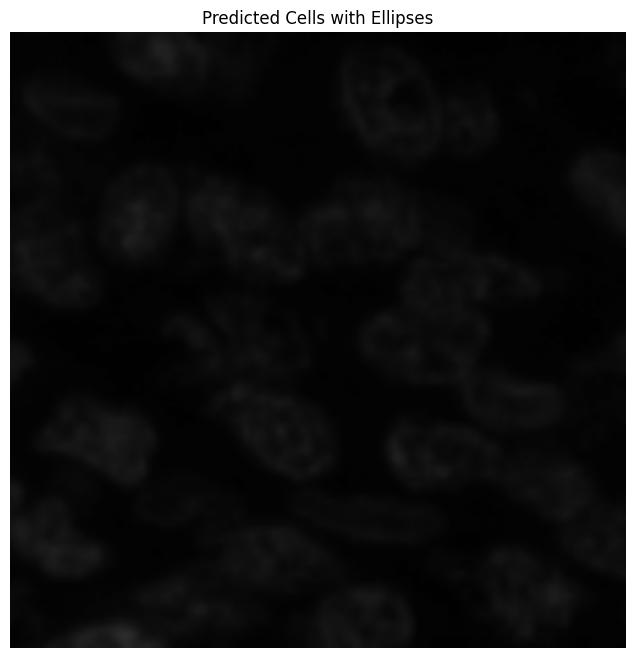

In [24]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import os

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("outputs", exist_ok=True)

# === Load trained model ===
model = maskrcnn_resnet50_fpn(num_classes=2)  # 1 class + background
model.load_state_dict(torch.load("model.pt", map_location=device))
model.to(device)
model.eval()

# === Load test data ===
with open("mock_test", "rb") as f:
    test_set = pickle.load(f)
print(f"Test set size: {len(test_set)}")

# === Pick sample image ===
sample_idx = 285
sample = test_set[sample_idx]
image_np = sample["image"]  # Grayscale image (H, W)

# === Convert grayscale to RGB tensor ===
image_pil = Image.fromarray(image_np.astype(np.uint8)).convert("RGB")
img_tensor = F.to_tensor(image_pil).unsqueeze(0).to(device)

# === Inference ===
with torch.no_grad():
    output = model(img_tensor)[0]  # Dict with 'boxes', 'labels', 'scores', 'masks'

# === Prepare base image for overlay ===
vis_image = cv2.cvtColor(image_np.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# === Draw ellipses ===
score_threshold = 0.1
ellipse_count = 0

for mask, score in zip(output["masks"], output["scores"]):
    if score.item() < score_threshold:
        continue

    binary_mask = (mask[0].cpu().numpy() > 0.5).astype(np.uint8)

    # Find contours and fit ellipses
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if len(cnt) >= 5 and cv2.contourArea(cnt) > 20:
            ellipse = cv2.fitEllipse(cnt)
            cv2.ellipse(vis_image, ellipse, (0, 255, 0), 2)
            ellipse_count += 1

print(f"Ellipses drawn: {ellipse_count}")

# === Save and show output ===
output_path = "outputs/predicted_ellipses.png"
cv2.imwrite(output_path, vis_image)
print(f"Saved overlay image: {output_path}")

# === Display image ===
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
plt.title("Predicted Cells with Ellipses")
plt.axis("off")
plt.show()



Test set size: 400
Number of detections: 7
Detection scores: [0.463, 0.463, 0.457, 0.457, 0.446, 0.445, 0.441]


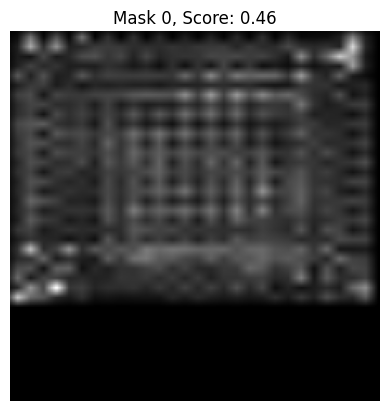

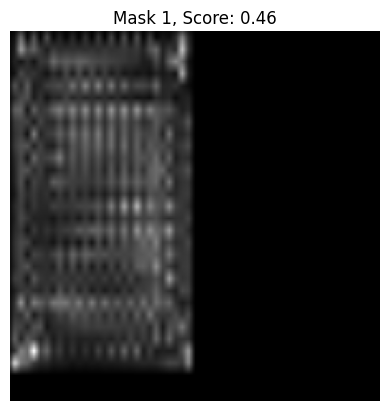

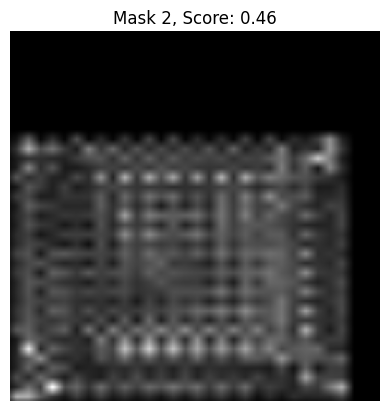

Mask 0: 0 contours
Detection 0: score=0.463, 0 contours found
Mask 1: 0 contours
Detection 1: score=0.463, 0 contours found
Mask 2: 0 contours
Detection 2: score=0.457, 0 contours found
Mask 3: 1 contours
Detection 3: score=0.457, 1 contours found
  Contour 0: area=0.00, points=1
Mask 4: 0 contours
Detection 4: score=0.446, 0 contours found
Mask 5: 0 contours
Detection 5: score=0.445, 0 contours found
Mask 6: 0 contours
Detection 6: score=0.441, 0 contours found
Ellipses drawn: 0
Saved overlay image: outputs/predicted_ellipses.png


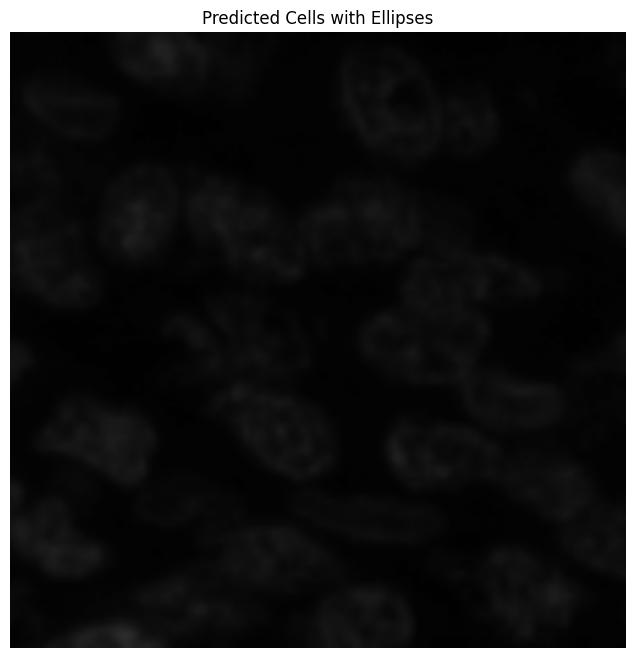

In [27]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import os

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("outputs", exist_ok=True)

# === Load trained model ===
model = maskrcnn_resnet50_fpn(num_classes=2)  # 1 class + background
model.load_state_dict(torch.load("model.pt", map_location=device))
model.to(device)
model.eval()

# === Load test data ===
with open("mock_test", "rb") as f:
    test_set = pickle.load(f)

print(f"Test set size: {len(test_set)}")

# === Pick sample image ===
sample_idx = 285
sample = test_set[sample_idx]
image_np = sample["image"]  # Grayscale image (H, W)

# === Convert grayscale to RGB tensor ===
image_pil = Image.fromarray(image_np.astype(np.uint8)).convert("RGB")
img_tensor = F.to_tensor(image_pil).unsqueeze(0).to(device)

# === Inference ===
with torch.no_grad():
    output = model(img_tensor)[0]

# === Debug print ===
print("Number of detections:", len(output["scores"]))
print("Detection scores:", [round(s.item(), 3) for s in output["scores"]])

# === Visualize first few masks (up to 3) ===
for i, mask in enumerate(output["masks"][:3]):
    plt.imshow(mask[0].cpu().numpy(), cmap='gray')
    plt.title(f"Mask {i}, Score: {output['scores'][i].item():.2f}")
    plt.axis("off")
    plt.show()

# === Prepare base image for overlay ===
vis_image = cv2.cvtColor(image_np.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# === Draw ellipses ===
score_threshold = 0.1
ellipse_count = 0
debug = True

for i, (mask, score) in enumerate(zip(output["masks"], output["scores"])):
    if score.item() < score_threshold:
        print(f"Skipping mask {i} (score: {score.item():.3f})")
        continue

    binary_mask = (mask[0].cpu().numpy() > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"Mask {i}: {len(contours)} contours")
    # === Draw ellipses and print contour info ===
    if debug:
        print(f"Detection {i}: score={score.item():.3f}, {len(contours)} contours found")

    for j, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if debug:
            print(f"  Contour {j}: area={area:.2f}, points={len(cnt)}")

        if len(cnt) >= 5 and area > 20:
            ellipse = cv2.fitEllipse(cnt)
            cv2.ellipse(vis_image, ellipse, (0, 255, 0), 2)
            ellipse_count += 1


print(f"Ellipses drawn: {ellipse_count}")

# === Save and show output ===
output_path = "outputs/predicted_ellipses.png"
cv2.imwrite(output_path, vis_image)
print(f"Saved overlay image: {output_path}")

# === Display image ===
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
plt.title("Predicted Cells with Ellipses")
plt.axis("off")
plt.show()
